## Assignment 8: PCA, Clustering, and Unsupervised Learning

### Stefenie Pickston 
#### 1506427

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


#### 1. Data Preparation. 

Loading and preparing the data. 

In [2]:
from datetime import datetime 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Note the seperator keyword here, it is because the data in the file is tab separated rather than comma seperated
df=pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv',sep='\t') 


## The following code creates features that would be helpful to describe the profile of the customer 
#  creates a new field to store the age of the customer, 
#  recodes the customer's education level to numeric form (0: high-school, 1: diploma, 2: bachelors, 3: masters, and 4: doctorates)
#  recodes the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner) 
#  creates a new field to store the number of children in the household
#  creates a new field to store the household size

df['Age']=2022-df['Year_Birth'] 
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True)
df['Children']=df['Kidhome']+df['Teenhome']
df['Family_Size']=df['Marital_Status']+df['Children']+1

## The following code creates features that would be helpful to describe the customer's purchasing preference and behaivior
#  creates a new field to store the total spending of the customer
#  creates subsequent fields to store the spending proportion for each product by the customer

df['Total_Spending']=df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df['Prop_Wines']=df["MntWines"]/df["Total_Spending"]
df['Prop_Fruits']=df["MntFruits"]/df["Total_Spending"]
df['Prop_MeatProducts']=df["MntMeatProducts"]/df["Total_Spending"]
df['Prop_FishProducts']=df["MntFishProducts"]/df["Total_Spending"]
df['Prop_SweetProducts']=df["MntSweetProducts"]/df["Total_Spending"]
df['Prop_GoldProds']=df["MntGoldProds"]/df["Total_Spending"]

## The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
today=datetime.today()
df['Days_as_Customer']=(today-df['Dt_Customer']).dt.days
df['Offers_Responded_To']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']

## The following code remove outliers in the dataset that are plausibly caused by data-entry errors (improbable values) 
#  Generally, we would remove outliers when we do customer segmentation, as we are more interested in the general population rather than the outliers
df = df[(df["Age"]<90)]
df = df[(df["Income"]<110000)]
df = df[(df["NumWebVisitsMonth"]<11)]
df = df[(df["NumWebPurchases"]<20)]
df = df[(df["NumCatalogPurchases"]<20)] 

## Finally we are going to drop some of the fields that are no longer relevant / unhelpful for the clustering
#  Note: depending on the question we would like to have answered, there is a case we can make to keep 
#  'MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts' and 'MntGoldProds', however 
#  because we are interested in the purchasing preferance rather than amount spent, the field for the spending 
#  proportion we created above would be more helpful
#  We dropped the responses to the individual promotions because very few customers react to those promotions 
#  (not enough to form their own clusters), so instead we look at the overall response, using the field created above
#  Less than 1% of customers filed a complaint. We drop the field as it wouldn't create a meaningful cluster
fields_to_drop=['ID','Year_Birth','Dt_Customer','Z_CostContact','Z_Revenue','AcceptedCmp1',
            'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain',
            'MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
df.drop(fields_to_drop,axis=1,inplace=True)
df.dropna(inplace=True)

## Helper function for to do 3d scatter plots, 
def scatter_3d(x,y,z,c=None):
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(111, projection='3d', label="bla")
    ax.scatter(x, y, z, s=40, c=c, marker='o',cmap=plt.cm.viridis)
    ax.set_title("The Plot Of The Clusters")
    plt.show()

### 2. PCA

a.) Apply StandardScaler preprocessing on the dataframe df, and assigned the fit_transformed values as df_scaled.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df)

print("SCALED: ", df_scaled)

SCALED:  [[-0.45432982 -1.35083021  0.30773769 ... -0.61059243  1.97260406
   0.61111078]
 [-0.45432982 -1.35083021 -0.26935211 ...  0.96737653 -1.66697063
  -0.50518491]
 [-0.45432982  0.74028548  0.96708015 ... -0.61339531 -0.17414271
  -0.50518491]
 ...
 [-0.45432982 -1.35083021  0.25112476 ... -0.94050296 -0.84957206
   0.61111078]
 [ 0.54255804  0.74028548  0.85121203 ... -0.44189833 -0.84526996
  -0.50518491]
 [ 1.5394459   0.74028548  0.04992133 ...  0.02577736  1.15950759
   0.61111078]]


b.) apply PCA transformation on df_scaled using all 23 components

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 23)

df_scaled_transformed = pca.fit_transform(df_scaled)

print ("PCA Transformed: ", df_scaled_transformed)

PCA Transformed:  [[ 3.03098211e+00 -1.27761439e+00  1.71879651e+00 ...  2.45699799e-14
   1.94996024e-15  6.71044570e-16]
 [-2.36339227e+00  5.67760829e-01 -1.39796662e+00 ... -4.37267659e-15
   1.58098743e-15  4.78759933e-15]
 [ 2.09587011e+00 -6.63923701e-01  4.89367999e-01 ... -7.23009666e-15
   6.16600428e-15  1.02676286e-15]
 ...
 [ 2.53695911e+00 -6.74771400e-01 -1.05960226e+00 ... -5.15395173e-17
  -1.25591420e-16  5.86601305e-17]
 [ 1.85006883e+00  1.09971276e+00  8.41868741e-02 ...  1.37366671e-16
  -3.77175382e-16  9.14456473e-18]
 [-1.51088583e+00  2.54464621e+00 -4.39893891e-01 ...  9.85226186e-18
  -3.77750814e-17 -8.74271943e-17]]


c.) Plot the cummulative variance explained by the principal components. 

In [5]:
#c8_11
principalComponents = pca.fit(df_scaled)
cummulative = np.cumsum(principalComponents.explained_variance_ratio_)
d = np.argmax(cummulative >= 0.80) + 1
print(d)

10


How many componenents do you need such that at least 80% of the variance is explained?

10 components are needed to have a variance of 0.8

d.)  Redo the PCA transformation on df_scaled using the same number of componenents as the value you worked out in 2c assigned the result of the transformation to df_transformed. 

In [6]:
pca = PCA(n_components = 10)
df_transformed = pca.fit_transform(df_scaled)
print("Adjusted PCA Transformation: ", df_transformed)

Adjusted PCA Transformation:  [[ 3.03098211 -1.27761439  1.71879651 ... -0.19857056  1.68398636
   0.07446586]
 [-2.36339227  0.56776083 -1.39796662 ...  1.26780365  0.85450444
   0.42932586]
 [ 2.09587011 -0.6639237   0.489368   ... -1.51342489 -0.864382
   0.77613961]
 ...
 [ 2.53695911 -0.6747714  -1.05960226 ...  0.64448136 -2.11071105
   0.43975374]
 [ 1.85006883  1.09971276  0.08418687 ... -0.89873682  0.35194894
   0.33422263]
 [-1.51088583  2.54464621 -0.43989389 ... -0.25966198  2.15865898
  -0.794889  ]]


e.) Visualize the first 3 components of df_transformed using a 3d scatter plot, (Hint: you may use the helper function scatter_3d)

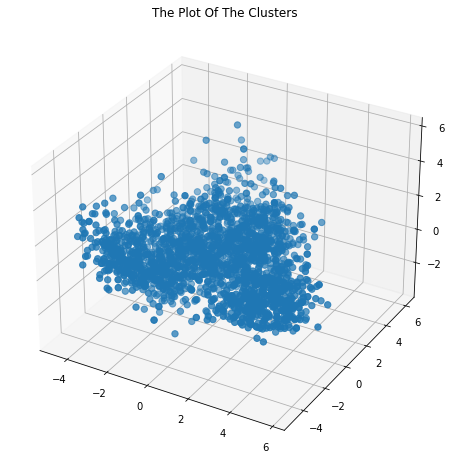

In [7]:
#visualisation
scatter_3d(df_transformed[:,0], df_transformed[:,1], df_transformed[:,2])

### 3. KMeans Clustering

a.) Apply KMeans clustering to df_transformed and measure the inertia score for n_clusters between 2 and 10

In [8]:
kArray = []
for i in range(2, 10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(df_transformed)
    inertia_score=kmeans.inertia_
    kArray.append(inertia_score)

b.) Plot the inertia score. 

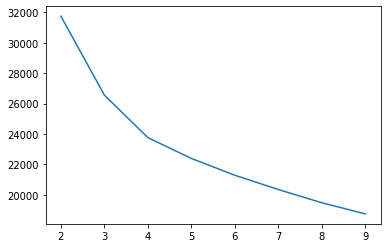

In [9]:
#plot
plt.plot(kArray)
plt.xticks(np.arange(len(kArray)),np.arange(2,len(kArray)+2))
plt.show()

What would you say is the best number of clusters for this dataset? Why?

4 is the best number of clusters because there is an elbow in the graph, 4-5 is a more lenient drop

c.) Find the cluster labels of KMeans(n_clusters=4) on df_transformed, (It doesn't matter what your answer for 3b is, set n_clusters=4)

In [10]:
kmeans=KMeans(n_clusters=4, random_state=1506427)
kmeans.fit(df_transformed)
inertia_score=kmeans.inertia_
y_labels = kmeans.fit_predict(df_transformed)

d.) Assign the cluster labels as df['Clusters']

In [11]:
df['Clusters'] = y_labels
print(df['Clusters'])

0       1
1       0
2       1
3       2
4       0
       ..
2235    3
2236    0
2237    1
2238    3
2239    0
Name: Clusters, Length: 2192, dtype: int32


e.) Visualize the first 3 components of df_transformed using a 3d scatter plot, with the data points coloured according to the clusters

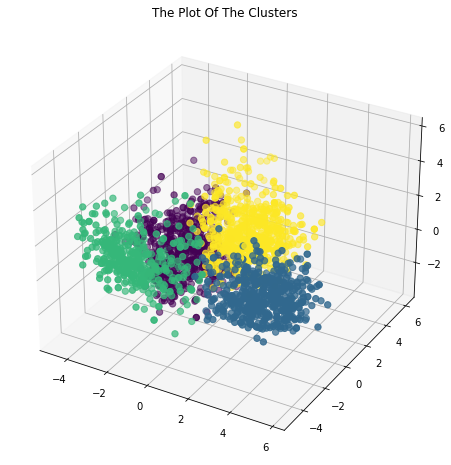

In [12]:
#visualisation
scatter_3d(df_transformed[:,0], df_transformed[:,1], df_transformed[:,2], df['Clusters'])

### 4. Interpreting our results. 

a.) Do a scatter plot between df['Income'] and df['Total_spending'] and colour the data points according the clusters.

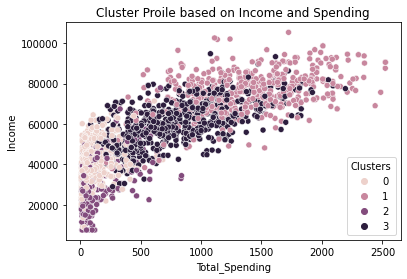

In [13]:
#scatterplot
pl = sns.scatterplot(data=df, x="Total_Spending", y = "Income", hue = "Clusters")
pl.set_title("Cluster Proile based on Income and Spending")
plt.show()

b.) Do a boxplot by clusters, for each of these following fields describing the attributes of the customer ['Age'.'Education','Marital_Status','Income', 'Children', 'Family_Size','Kidhome','Teenhome']

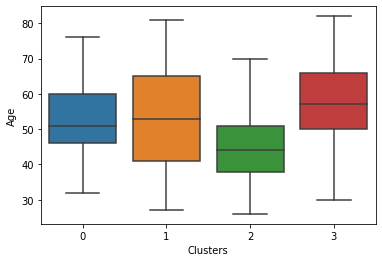

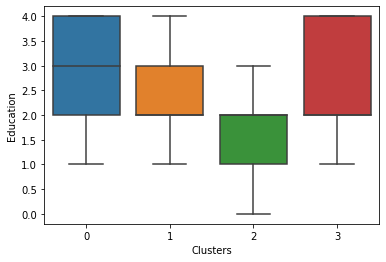

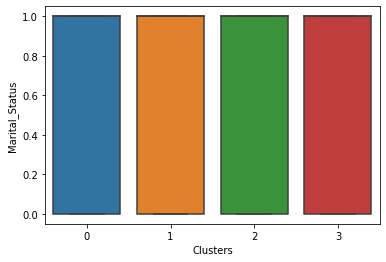

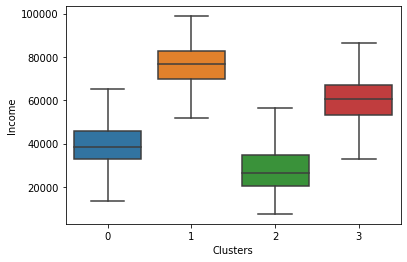

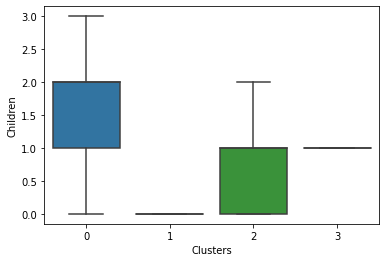

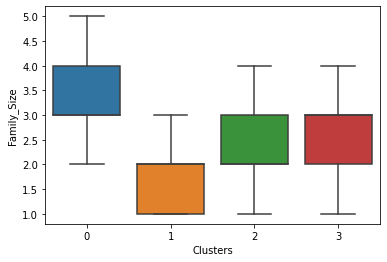

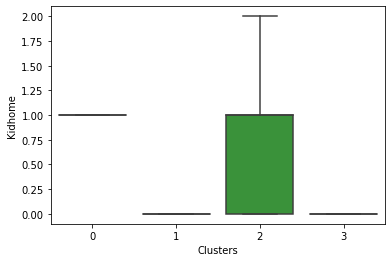

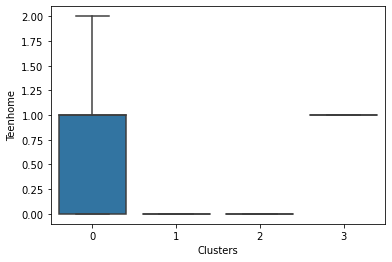

In [14]:
#boxplot
def box_plot(y):
    for i in y:
        sns.boxplot(data = df, x = 'Clusters', y = i, showfliers = False)
        plt.show()
        
y = ['Age','Education','Marital_Status','Income', 'Children', 'Family_Size','Kidhome','Teenhome']
box_plot(y)

c.) Do a boxplot by clusters, for each of these following fields describing the customer preference ['Total_Spending','Prop_Wines','Prop_Fruits','Prop_MeatProducts','Prop_FishProducts','Prop_SweetProducts','Prop_GoldProds']

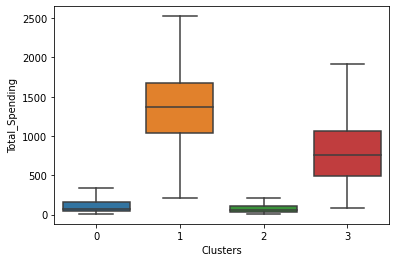

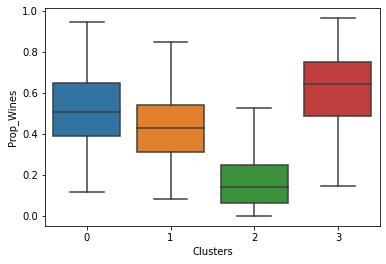

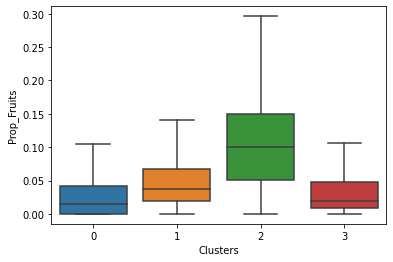

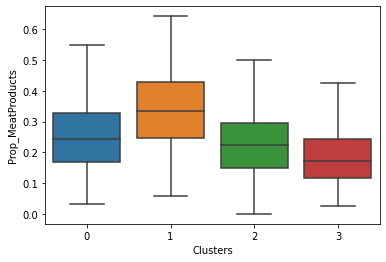

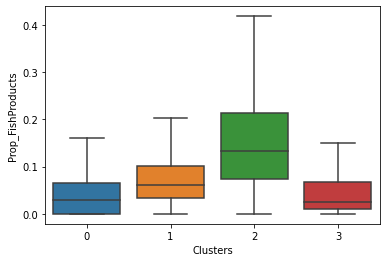

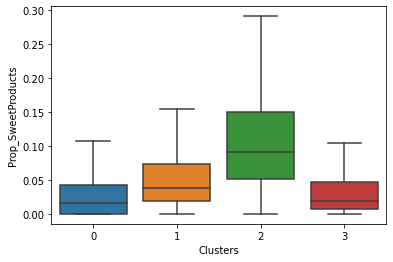

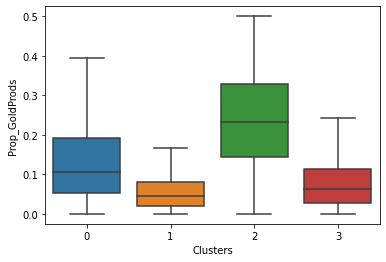

In [15]:
#boxplot
y2 = ['Total_Spending','Prop_Wines','Prop_Fruits','Prop_MeatProducts','Prop_FishProducts','Prop_SweetProducts','Prop_GoldProds']
box_plot(y2)

d.) Do a boxplot by clusters, for each of these following fields describing the customer behaivoir
	   ['Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Days_as_Customer', 'Offers_Responded_To'],

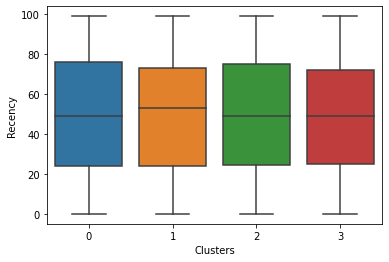

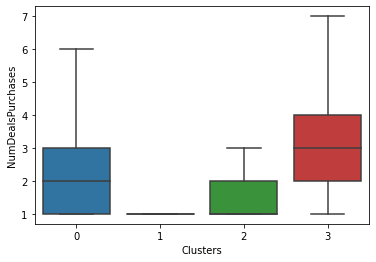

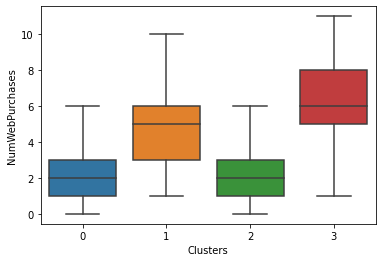

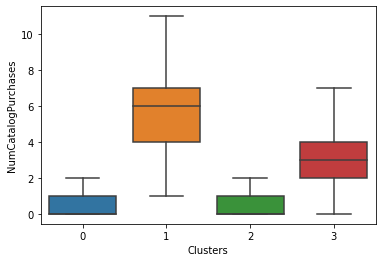

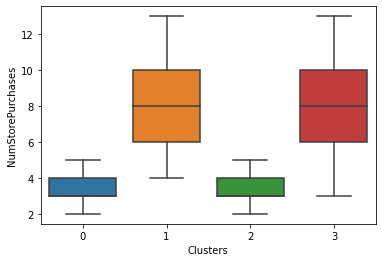

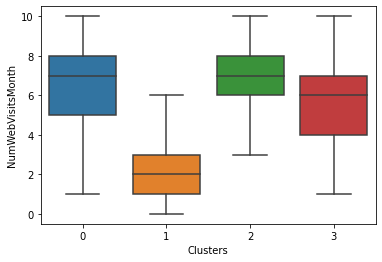

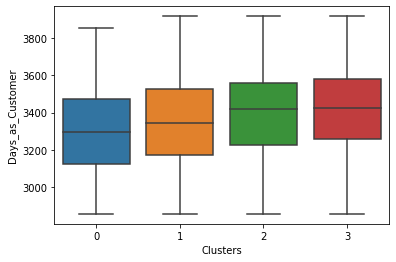

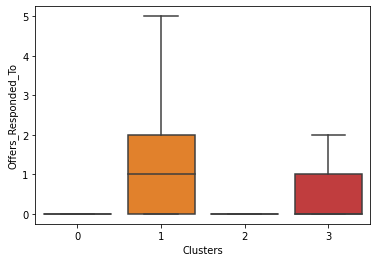

In [16]:
#boxplot
y3 = ['Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Days_as_Customer', 'Offers_Responded_To']
box_plot(y3)

e.) Obtain the means grouped by the cluster, for each of the fields. (See hint for a 1-liner code)

In [17]:
df.groupby('Clusters').mean().T

Clusters,0,1,2,3
Education,2.733547,2.505859,1.653012,2.665109
Marital_Status,0.678973,0.587891,0.624096,0.674455
Income,39098.995185,75882.820312,28427.727711,60193.596573
Kidhome,0.927769,0.023438,0.665060,0.163551
Teenhome,0.683788,0.044922,0.096386,0.967290
Recency,49.401284,49.445312,48.922892,48.498442
NumDealsPurchases,2.454254,1.046875,1.804819,3.484424
NumWebPurchases,2.382022,4.896484,2.166265,6.345794
NumCatalogPurchases,0.606742,5.912109,0.604819,3.344237
NumStorePurchases,3.394864,8.279297,3.296386,7.968847


f.) Build a profile of each of the clusters. 

For each of the clusters, are the customers in the cluster... 

<b>Cluster 0:</b>  
Usually younger/older? *Older customers, around the age of 53.*  
Low/high income? *A low income averaging at $39,099 anually*   
Married/single? *More likely to be married or together, less likely in comparison to other clusters however*  
Have children? kids? teens? *More likely to have two children, or a kid and a teen*  
Highly educated? *More likely to have a Masters degree*

Do they spend a lot with the company? *No, on average $115*  
What products do they usually purchase? *Wines and Meats*  

Are they customers who make purchases during deals? *In comparison to other clusters, sometimes, usually two times*  
Are they more likely to respond to offers? *No*  
When was their last purchase? *49 days ago on average*  

<b>Cluster 1:</b>  
Usually younger/older? *Older customers, around the age of 53.*  
Low/high income? *A high income averaging at $75,883 anually*   
Married/single? *More likely to be married or together*  
Have children? kids? teens? *More likely to have no children*  
Highly educated? *More likely to have a Masters or Bachelors degree*

Do they spend a lot with the company? *Yes, on average $1,368*  
What products do they usually purchase? *Wines and Meats*  

Are they customers who make purchases during deals? *No, usually only once*  
Are they more likely to respond to offers? *Yes*  
When was their last purchase? *49 days ago on average*

<b>Cluster 2:</b>  
Usually younger/older? *Younger customers, around the age of 46.*  
Low/high income? *A low income averaging at $28,427 anually*   
Married/single? *More likely to be married or together*  
Have children? kids? teens? *More likely to have 1 child who is a kid*  
Highly educated? *More likely to have a Bachelors degree or High School Diploma*

Do they spend a lot with the company? *No, on average $113*  
What products do they usually purchase? *Meat and Gold*  

Are they customers who make purchases during deals? *In comparison to other clusters, sometimes, usually two times*  
Are they more likely to respond to offers? *No*  
When was their last purchase? *49 days ago on average*

<b>Cluster 3:</b>  
Usually younger/older? *Older customers, around the age of 58.*  
Low/high income? *A high income averaging at $60,194 anually*   
Married/single? *More likely to be married or together*  
Have children? kids? teens? *More likely to have 1 child who is a teen*  
Highly educated? *More likely to have a Bachelors or Masters degree, but more educated than cluster 1*

Do they spend a lot with the company? *Yes, on average $803*  
What products do they usually purchase? *Wine*  

Are they customers who make purchases during deals? *Yes, usually three times*  
Are they more likely to respond to offers? *They are less likely to*  
When was their last purchase? *48 days ago on average*

*End of Assignment...*